#### 1. Importing Libraries


In [1]:
%matplotlib inline

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install googletrans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.2 MB/s 
     |████████████████████████████████| 1.4 MB 48.6 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
     |████████████████████████████████| 65 kB 3.7 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15735 sha256=ac2a427066101bef9a82fb79e3669462d9b467ba5f000df609fcca3cacf677a4
  Stored in directory: /root/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans


In [4]:
!pip install google_trans_new

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from googletrans import Translator
# for translating foreign languages to english
# https://stackoverflow.com/questions/67303463/how-to-translate-other-languages-to-english-in-pandas-dataframe

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 2. Reading files

In [63]:
# First df, 
sales_df = pd.read_csv('/content/drive/MyDrive/Projects/competitive-data-science-predict-future-sales/sales_train.csv')
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


#### 3. Data Processing and Analysis

##### 3.a Basic data check

In [8]:
# size of sales_df
sales_df.shape
# 29Lakh rows

(2935849, 6)

In [9]:
sales_df['date_block_num'].max()
# max value of these consecutive months; 0-- being Junuary,2013

33

In [10]:
# total number of shops
print(len(sales_df['shop_id'].unique()))
print(len(sales_df['item_id'].unique()))

60
21807


In [11]:
sales_df.info()
# checking the datatype of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [12]:
sales_df.isnull().sum()
# no null values it seems 

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

##### 3.b Converting date to proper format

In [13]:
# converting datetime column to correct format
sales_df['date'] = pd.to_datetime(sales_df['date'],format='%d.%m.%Y')
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


##### 3.c Understanding item_cnt_day column

[]

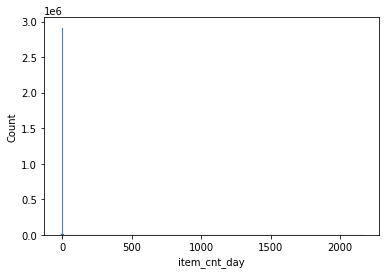

In [14]:
sns.histplot(sales_df, x='item_cnt_day', bins=300)
plt.plot()
# the distribution for item count sold is very skewed

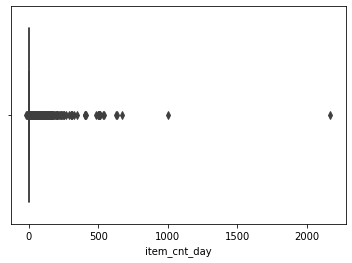

In [15]:
sns.boxplot(x=sales_df['item_cnt_day'])
# we can clip the data from 0 to 1000 as -ve values and value higher than 1000 is clearly outlier based on present sales data

In [16]:
sales_df.item_cnt_day.value_counts().head(20)
# value counts proves that most of the items are getting sold as 1(1 item each day per shop)
# there is only 1 item which got sold for 2169 times by a shop in a single day [better to remove this data from better modeling]
# item count is negative in some places which is junk

temp = sales_df.item_cnt_day.value_counts().sort_index(ascending=True).reset_index().rename(columns={'index':'item_cnt_day_value', 'item_cnt_day':'item_cnt_day_count'})
temp.loc[temp['item_cnt_day_count']>1].tail(10) 
#Observations: clearly shows that items are not sold that frequently beyond 500 times a day.
# so here, there are only two instances when an item was sold for 5000 times a day
# above 500 times, is very rare (only once for few items)

,item_cnt_day_value,item_cnt_day_count
142,145.0,2
145,148.0,2
147,150.0,2
148,151.0,5
157,168.0,2
158,171.0,3
164,205.0,2
178,313.0,2
181,401.0,2
185,500.0,2


In [17]:
print(len(sales_df[sales_df['item_cnt_day'] < 0])) # negative sales are there
print(len(sales_df[sales_df['item_cnt_day'] == 0])) # checking if item sold count is 0 anywhere
print(len(sales_df[sales_df['item_cnt_day'] > 0]))
print(len(sales_df[sales_df['item_cnt_day'] > 500])) # There are just 12 instances when the item sold in a day count went beyond 500

7356
0
2928493
12


In [18]:
# Let's see which items are those (whose sale was beyond 500 on a single day) and which shop sold those items?
sales_df[sales_df.item_cnt_day > 500].sort_values(by=['item_id'])
## Strange Observation: shop_id 12 sold the item_id 9248 at varying prices. But what's strange here is, when the item was sold in bulk, the price was high (opposite to normal market assumptions). 
# And if we look at the dates, we can see that they were sold on consecutive days.

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2608040,2015-04-14,27,12,3731,1904.548077,624.0
1573253,2014-04-22,15,27,8057,1200.000000,502.0
2048518,2014-10-02,21,12,9242,1500.000000,512.0
2864235,2015-09-30,32,12,9248,1692.526158,669.0
2864260,2015-09-29,32,12,9248,1500.000000,504.0
2851073,2015-09-29,32,55,9249,1500.000000,533.0
2851091,2015-09-30,32,55,9249,1702.825746,637.0
2626181,2015-05-19,28,12,11373,155.192950,539.0
2909818,2015-10-28,33,12,11373,0.908714,2169.0
2067669,2014-10-09,21,55,19437,899.000000,508.0


In [19]:
# Checking percentile on item_cnt_day

sales_df.item_cnt_day.quantile([0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,0.95,0.99])
## so 99 percentile value of item count is 5

0.10    1.0
0.20    1.0
0.25    1.0
0.30    1.0
0.40    1.0
0.50    1.0
0.60    1.0
0.70    1.0
0.75    1.0
0.80    1.0
0.90    2.0
0.95    2.0
0.99    5.0
Name: item_cnt_day, dtype: float64

In [20]:
print(list(sales_df[sales_df.item_cnt_day > 500].shop_id.unique())) # Out of all shops (60) only 4 shops are involved in such high sales in a single day
print(list(sales_df[sales_df.item_cnt_day > 500].item_id.unique())) # out of all items (21807) only 8 items are involved in such high sales

[27, 25, 12, 55]
[8057, 20949, 9242, 19437, 3731, 11373, 9249, 9248]


In [21]:
sales_df[sales_df['item_cnt_day'] > 0].groupby(['shop_id'], as_index=False).agg({'item_cnt_day':'sum'}).sort_values(by=['item_cnt_day'], ascending=False).reset_index(drop=True)
# Observations: based on item_cnt_day, largest shop's list
# sales_df[sales_df['item_cnt_day'] > 0].groupby(['shop_id'], as_index=False).agg({'item_cnt_day':[np.sum,pd.Series.nunique]}).reset_index(drop=True)

,shop_id,item_cnt_day
0,31,311230.0
1,25,242237.0
2,54,186149.0
3,28,184777.0
4,42,145195.0
5,57,141424.0
6,27,136815.0
7,6,100757.0
8,58,81908.0
9,46,79092.0


In [22]:
## Analysis on the highest priced item
print(len(sales_df))
print(len(sales_df[sales_df['item_cnt_day']>500]))
sales_df[sales_df['item_cnt_day'] == 2169].head()

# Observations: 
# 1. Most of the shops have sold 1 item most of the days
# 2. Only one item, by one particular shop (12,11373) whose price is less than 1 somehow sold that item on 28th Oct, 2015 
# more than 2k times

2935849
12


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,2015-10-28,33,12,11373,0.908714,2169.0


##### 3.d Understanding item_price column

[]

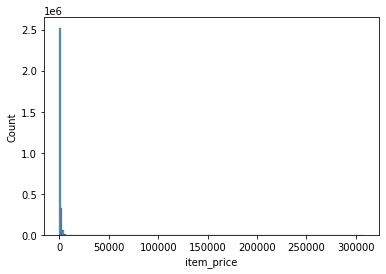

In [23]:
sns.histplot(sales_df, x='item_price', bins=200)
plt.plot()
# this also seems very skewed
# the prices of most of the items are quite low

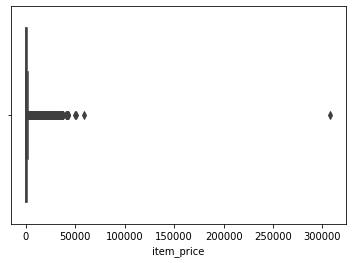

In [24]:
sns.boxplot(x=sales_df['item_price'])

In [25]:
print(sales_df.item_price.max())
print(sales_df.item_price.min())

307980.0
-1.0


In [26]:
sales_df.item_price.value_counts().reset_index().rename(columns={'index':'item_price', 'item_price':'row_counts'}).sort_values(by=['item_price'], ascending=True).reset_index(drop=True).head(20)#.reset_index().to_csv('item_price_list.csv')

# so there are products whose prices are less than 1 even

,item_price,row_counts
0,-1.000000,1
1,0.070000,2
2,0.087500,1
3,0.090000,1
4,0.100000,2932
5,0.200000,1
6,0.500000,1226
7,0.908714,1
8,0.990000,493
9,1.000000,1


In [27]:
sales_df.item_price.value_counts().reset_index().rename(columns={'index':'item_price', 'item_price':'row_counts'}).sort_values(by=['item_price'], ascending=False).reset_index(drop=True).head(20)#.reset_index().to_csv('item_price_list.csv')

# so there is one records with price 307980.0, rest all the less than 60k
# so we can clip item_price. The total row count of products with prices greater than 35k seems quite less

,item_price,row_counts
0,307980.0,1
1,59200.0,1
2,50999.0,1
3,49782.0,1
4,42990.0,4
5,42000.0,1
6,41990.0,3
7,40991.0,1
8,40900.0,1
9,37991.0,2


In [28]:
sales_df[sales_df.item_price == 307980.0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


In [29]:
sales_df.item_price.value_counts().reset_index().rename(columns={'index':'item_price', 'item_price':'row_counts'}).sort_values(by=['row_counts'], ascending=False).reset_index(drop=True).head(20)#.reset_index().to_csv('item_price_list.csv')
# 299, 399 seems quite common price for products with row counts more than 2lkhs

,item_price,row_counts
0,299.0,291352
1,399.0,242603
2,149.0,218432
3,199.0,184044
4,349.0,101461
5,599.0,95673
6,999.0,82784
7,799.0,77882
8,249.0,77685
9,699.0,76493


In [30]:
# this high price materials are from different shops or same shop?
len(sales_df[sales_df['item_price'] == 299].shop_id.unique()) 
#so out of 60 shops almost 59 have that range's product

59

In [31]:
len(sales_df[sales_df['item_price'] == 299].item_id.unique()) # and multiple items has that price

2749

In [32]:
print(len(sales_df[sales_df['item_price'] == 399].shop_id.unique()) )
print(len(sales_df[sales_df['item_price'] == 399].item_id.unique()))

59
1929


In [33]:
sales_df[sales_df.item_price > 30000]
# only 240 records out of 2935849 records are greater than 30k.

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2113,2013-01-30,0,24,5748,32990.0,1.0
322740,2013-03-15,2,24,5748,32990.0,1.0
679950,2013-07-05,6,22,5748,32990.0,1.0
884848,2013-09-11,8,12,2410,36990.0,1.0
885020,2013-09-30,8,13,2410,32437.0,1.0
...,...,...,...,...,...,...
2932600,2015-10-26,33,25,13449,32990.0,1.0
2932637,2015-10-26,33,25,13403,37991.0,1.0
2935491,2015-10-30,33,25,6674,30990.0,1.0
2935492,2015-10-17,33,25,6674,32990.0,1.0


In [34]:
sales_df[sales_df.item_price > 6000]
# only 240 records out of 2935849 records are greater than 30k.

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1066,2013-01-18,0,25,4861,8490.0,1.0
1203,2013-01-20,0,25,5613,6190.0,1.0
1701,2013-01-03,0,25,4384,13499.0,1.0
1949,2013-01-05,0,24,5371,8290.0,1.0
1950,2013-01-24,0,24,5371,7590.0,1.0
...,...,...,...,...,...,...
2935504,2015-10-19,33,25,6674,32990.0,1.0
2935654,2015-10-01,33,25,7903,12198.0,1.0
2935661,2015-10-07,33,25,7668,7990.0,1.0
2935662,2015-10-27,33,25,7668,7990.0,1.0


In [35]:
sales_df.item_price.quantile([0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,0.95,0.99])
## so 99 percentile value of item count is 5999

0.10     149.0
0.20     199.0
0.25     249.0
0.30     299.0
0.40     349.0
0.50     399.0
0.60     599.0
0.70     799.0
0.75     999.0
0.80    1199.0
0.90    1999.0
0.95    2690.0
0.99    5999.0
Name: item_price, dtype: float64

#### 4. Loading other helper dataframes

In [36]:
# loading other dataframe
item_cat_df = pd.read_csv('/content/drive/MyDrive/Projects/competitive-data-science-predict-future-sales/item_categories.csv')
items_df = pd.read_csv('/content/drive/MyDrive/Projects/competitive-data-science-predict-future-sales/items.csv')
shops_df = pd.read_csv('/content/drive/MyDrive/Projects/competitive-data-science-predict-future-sales/shops.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Projects/competitive-data-science-predict-future-sales/test.csv')

In [37]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [38]:
item_cat_df.head(10)
# print(item_cat_df.shape) #(84, 2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [39]:
# items_df.shape #(22170, 3)
items_df.head(15)
# Observations from item_df and item_cat_df we can see that in one item category

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [40]:
# shops_df.shape (60, 2)
shops_df.head(15)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [41]:
## Checking the shop IDs and item IDs present in train test dataset
# test_df.head()
# sales_df.head()
common_shop_ids = set(sales_df[sales_df['shop_id'].isin(test_df.shop_id.unique())].shop_id.unique())
sales_shop_ids = set(sales_df.shop_id.unique())
sales_shop_ids-common_shop_ids # of shop IDs

{0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54}

In [42]:
## Checking the shop IDs and item IDs present in train test dataset
# test_df.head()
# sales_df.head()
common_item_ids = set(sales_df[sales_df['item_id'].isin(test_df.item_id.unique())].item_id.unique())
sales_item_ids = set(sales_df.item_id.unique())
len(sales_item_ids-common_item_ids) # of shop IDs

17070

#### 5. Merging all the dataframes

In [43]:
final_df = pd.merge(sales_df,items_df,how='left',on='item_id') # sales df + item_df
final_df = pd.merge(final_df, item_cat_df, how='left', on='item_category_id') # sales df + item_df + item_cat_df
final_df = pd.merge(final_df, shops_df, how='left', on = 'shop_id') # sales df + item_df + item_cat_df + shop_df
final_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


In [44]:
print(final_df.date_block_num.nunique())
print(final_df.shop_id.nunique())
print(final_df.item_price.nunique())
print(final_df.item_id.nunique())
print(final_df.item_cnt_day.nunique())
print(final_df.item_category_id.nunique())

34
60
19993
21807
198
84


In [45]:
final_df[final_df['item_price']<=0]
# record where item price got recorded as -ve

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
484683,2013-05-15,4,32,2973,-1.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""


In [46]:
final_df[final_df['item_price']==307980.0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
1163158,2013-12-13,11,12,6066,307980.0,1.0,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса,Интернет-магазин ЧС


In [47]:
final_df[final_df['item_id'] == 2973].item_price.unique()
# same item has got different prices (quite interesting)

array([ 2.49900000e+03,  2.42757143e+03,  2.49850000e+03,  2.49883333e+03,
        2.49875000e+03,  2.49891667e+03,  1.90100000e+03,  1.99900000e+03,
        2.49887500e+03,  2.49890000e+03,  2.24900000e+03,  2.37395000e+03,
        2.49870000e+03,  2.49840000e+03,  1.99840000e+03,  1.24950000e+03,
        1.24900000e+03,  1.24910000e+03, -1.00000000e+00,  1.24890000e+03,
        1.04900000e+03,  2.24880000e+03,  1.56203000e+03,  1.48761000e+03,
        1.27527000e+03,  1.27501000e+03,  1.38840000e+03,  1.32929000e+03,
        1.52391000e+03,  1.83785000e+03,  1.45300000e+03,  1.45412000e+03,
        1.29758000e+03,  1.25000000e+03,  1.24870000e+03,  1.83237000e+03])

In [48]:
final_df[final_df['item_cnt_day']<0].sort_values(by=['item_cnt_day'], ascending=True).reset_index(drop=True)
## 7356 recrods has got negative item sales
## which is equivalent to 0.250 percent of whole data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,2013-11-02,10,12,8023,15.000000,-22.0,ZL004 Лазерные наклейки Смайлики маленькие,66,"Подарки - Открытки, наклейки",Интернет-магазин ЧС
1,2014-07-10,18,14,20949,5.000000,-16.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши","Казань ТЦ ""ПаркХаус"" II"
2,2014-10-10,21,12,9242,1433.333333,-9.0,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",8,Билеты (Цифра),Интернет-магазин ЧС
3,2013-01-18,0,12,1590,2599.000000,-6.0,"Assassin’s Creed 3. Freedom Edition [PC, русск...",29,Игры PC - Коллекционные издания,Интернет-магазин ЧС
4,2013-10-19,9,42,3732,2599.000000,-6.0,"Grand Theft Auto V [PS3, русские субтитры]",19,Игры - PS3,"СПб ТК ""Невский Центр"""
...,...,...,...,...,...,...,...,...,...,...
7351,2013-10-05,9,7,3423,1499.000000,-1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360,"Воронеж ТРЦ ""Максимир"""
7352,2013-10-01,9,6,17695,499.000000,-1.0,"Последняя воля Шерлока Холмса [PC, Jewel, русс...",30,Игры PC - Стандартные издания,"Воронеж (Плехановская, 13)"
7353,2013-10-22,9,6,21925,399.000000,-1.0,ШУТКИ В СТОРОНУ (BD),37,Кино - Blu-Ray,"Воронеж (Плехановская, 13)"
7354,2013-10-02,9,15,7047,599.000000,-1.0,Tom Clancy's Splinter Cell: Blacklist. Standar...,30,Игры PC - Стандартные издания,"Калуга ТРЦ ""XXI век"""


In [49]:
d = final_df.groupby('shop_id').size().reset_index(name='counts').rename(columns={'0':'count'}).sort_values(by=['counts'], ascending=False)
d[d.counts> 50000]

,shop_id,counts
31,31,235636
25,25,186104
54,54,143480
28,28,142234
57,57,117428
42,42,109253
27,27,105366
6,6,82663
58,58,71441
56,56,69573


In [50]:
# 50th Percentile
def q50(x):
    return x.quantile(0.5)

# 90th Percentile
def q90(x):
    return x.quantile(0.9)

d=final_df.groupby(['shop_id']).agg({'item_cnt_day': [q50, q90, 'max']})
d.columns = d.columns.droplevel()
d = d.rename(columns={'q50':'item_cnt_day_q50', 'q90':'item_cnt_day_q90', 'max':'item_cnt_day_max'})
d


,item_cnt_day_q50,item_cnt_day_q90,item_cnt_day_max
shop_id,,,
0,1.0,2.0,11.0
1,1.0,1.0,13.0
2,1.0,1.0,71.0
3,1.0,1.0,83.0
4,1.0,1.0,104.0
5,1.0,1.0,98.0
6,1.0,1.0,148.0
7,1.0,1.0,67.0
8,1.0,1.0,6.0


#### 5.b Checking Correlation between Item_price and Item_cnt across month, shops

In [51]:
# Grouping data by shop_id, item_id, item_category_id
# to check count of shops, items and item_categories per month
no_of_shop_in_month = final_df.groupby('date_block_num').agg(
    shops  = ('shop_id' , pd.Series.nunique),
    item_id  = ('item_id', pd.Series.nunique),
    category_id  = ('item_category_id', pd.Series.nunique)
).sort_values(by='date_block_num').reset_index()
no_of_shop_in_month

,date_block_num,shops,item_id,category_id
0,0,45,8115,56
1,1,46,8168,57
2,2,46,8302,53
3,3,46,8145,54
4,4,45,8339,60
5,5,46,8478,57
6,6,46,8405,59
7,7,45,8031,59
8,8,45,7876,59
9,9,46,8039,61


In [52]:
## grouping data by date_block_num, shop_id, item_id
## 
lvled_data = final_df.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    item_category_id  = ('item_category_id', pd.Series.unique),
        shop_name  = ('shop_name', pd.Series.unique),
    item_name  = ('item_name', pd.Series.unique),
    item_category_name  = ('item_category_name', pd.Series.unique),
    item_price  = ('item_price' , sum),
    item_cnt_day  = ('item_cnt_day', sum)
).sort_values(by='shop_id').reset_index()
lvled_data.head()

,date_block_num,shop_id,item_id,item_category_id,shop_name,item_name,item_category_name,item_price,item_cnt_day
0,0,0,32,40,"!Якутск Орджоникидзе, 56 фран",1+1,Кино - DVD,884.0,6.0
1,1,0,7894,6,"!Якутск Орджоникидзе, 56 фран",X360: Геймпад проводной чёрный - Controller BL...,Аксессуары - XBOX 360,9888.0,9.0
2,1,0,7893,6,"!Якутск Орджоникидзе, 56 фран",X360: Геймпад беспроводной черный - Wireless C...,Аксессуары - XBOX 360,20622.0,26.0
3,1,0,7892,6,"!Якутск Орджоникидзе, 56 фран",X360: Геймпад беспроводной черный + Halo 4 (GT...,Аксессуары - XBOX 360,11336.0,4.0
4,1,0,7882,6,"!Якутск Орджоникидзе, 56 фран",X360: Super ZOOM [только для Kinect],Аксессуары - XBOX 360,5140.0,5.0


##### How Item counts are varying with Price within each shops

In [54]:
# total_corr = 0
corr_df = pd.DataFrame(columns=('shop_id', 'correlation'))
shop_id = lvled_data.shop_id.unique().tolist()

## looping over all shop ids and figuring out per shop item_price vs item_cnt_day
for i in shop_id:
  lvled_data_oneshop = lvled_data[lvled_data['shop_id']==i]
  one_corr = lvled_data_oneshop['item_price'].corr(lvled_data_oneshop.item_cnt_day)
  corr_df = corr_df.append({'shop_id':i, 'correlation':one_corr}, ignore_index=True)
  
corr_df.shop_id = corr_df.shop_id.astype(int)
corr_df

,shop_id,correlation
0,0,0.284646
1,1,0.230904
2,2,0.348810
3,3,0.283086
4,4,0.185246
5,5,0.211806
6,6,0.242808
7,7,0.216751
8,8,0.407088
9,9,0.050977


Text(0, 0.5, 'Corr Item_Price Item_Cnt')

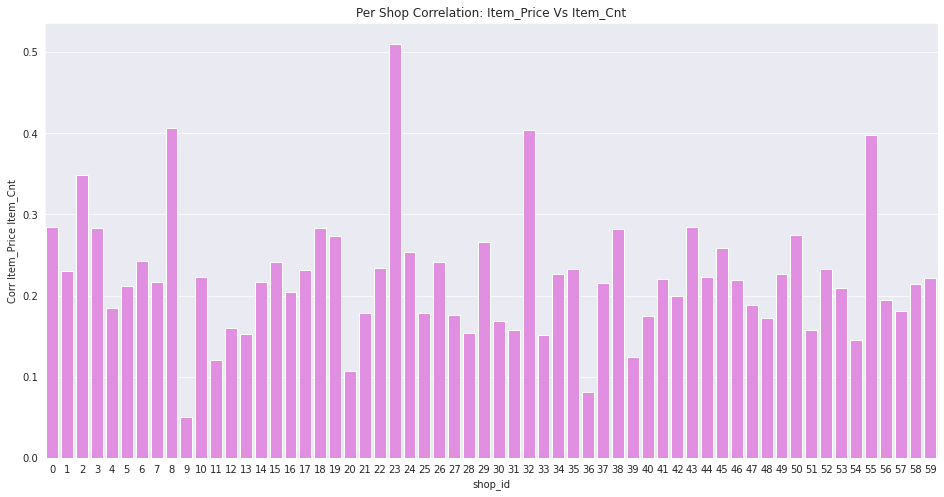

In [55]:
plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
# pal = sns.color_palette("Greens_d", len(corr_df))
# rank = corr_df.argsort().argsort()


ax = sns.barplot(x='shop_id', y='correlation', data=corr_df,color = 'violet')# palette=np.array(pal[::-1])[rank])
ax.set_title('Per Shop Correlation: Item_Price Vs Item_Cnt')
ax.set_ylabel('Corr Item_Price Item_Cnt')

##### How item counts are varying with price across months each year

In [56]:
# total_corr = 0
corr_df2 = pd.DataFrame(columns=('date_block_num', 'correlation'))

date_block_num = lvled_data.date_block_num.unique().tolist()

## Across each month checking correlation between item_price and item_cnt_day
for i in date_block_num:
  lvled_data_month = lvled_data[lvled_data['date_block_num']==i]
  one_corr2 = lvled_data_month['item_price'].corr(lvled_data_month.item_cnt_day)
  corr_df2 = corr_df2.append({'date_block_num':i, 'correlation':one_corr2}, ignore_index=True)


In [57]:
corr_df2.date_block_num = corr_df2.date_block_num.astype(int)
corr_df2.head()

,date_block_num,correlation
0,0,0.353380
1,1,0.390295
2,27,0.237587
3,2,0.431691
4,3,0.389079


Text(0, 0.5, 'Corr Item_Price Item_Cnt')

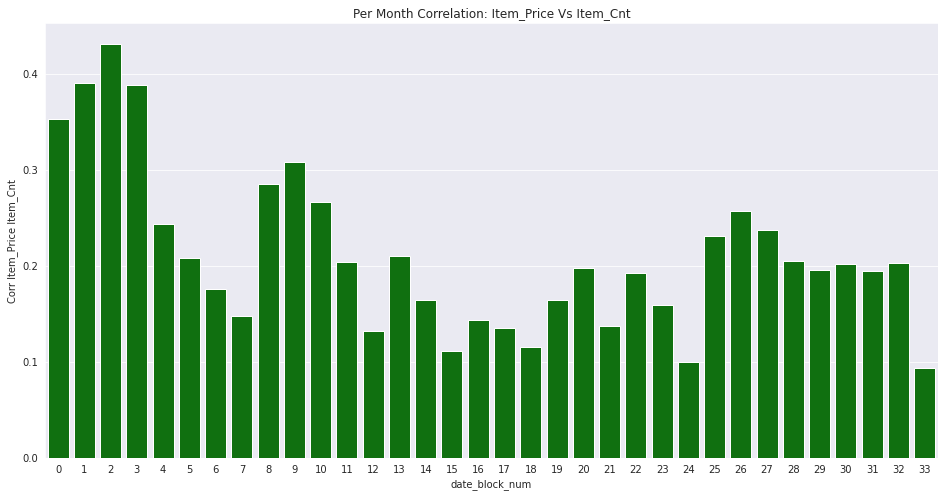

In [58]:
plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
# pal = sns.color_palette("Greens_d", len(corr_df))
# rank = corr_df.argsort().argsort()


ax = sns.barplot(x='date_block_num', y='correlation', data=corr_df2,color = 'green')# palette=np.array(pal[::-1])[rank])
ax.set_title('Per Month Correlation: Item_Price Vs Item_Cnt')
ax.set_ylabel('Corr Item_Price Item_Cnt')

In [59]:
## Across each year correlation between item_price vs item_cnt_day
lvled_data_2013 = lvled_data[lvled_data['date_block_num']<12]
lvled_data_2014 = lvled_data[(lvled_data['date_block_num']> 11) & (lvled_data['date_block_num']<24)]
lvled_data_2015 = lvled_data[lvled_data['date_block_num']>23]

print("Corr across months in 2013 is: ", lvled_data_2013.item_price.corr(lvled_data_2013.item_cnt_day))
print("Corr across months in 2014 is: ", lvled_data_2014.item_price.corr(lvled_data_2014.item_cnt_day))
print("Corr across months in 2015 is: ", lvled_data_2015.item_price.corr(lvled_data_2015.item_cnt_day))

Corr across months in 2013 is:  0.22814487469571712
Corr across months in 2014 is:  0.1575453569404927
Corr across months in 2015 is:  0.1574259300493679


#### 6. Creating features out of Date Column

In [60]:
temp_df = final_df.copy() # deep copy

In [61]:
## creating various date features
temp_df['week'] = final_df['date'].dt.week
temp_df['weekday'] = final_df['date'].dt.weekday
temp_df['month'] = final_df['date'].dt.month
temp_df['year'] = final_df['date'].dt.year
temp_df[['date', 'week', 'weekday', 'month', 'year']].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,date,week,weekday,month,year
0,2013-01-02,1,2,1,2013
1,2013-01-03,1,3,1,2013
2,2013-01-05,1,5,1,2013
3,2013-01-06,1,6,1,2013
4,2013-01-15,3,1,1,2013


In [ ]:
# checking total item sell, and item_price across year, month
temp_df.groupby(['year','month'], as_index=False).agg({'item_cnt_day':'sum', 'item_price':'sum'}).sort_values(by=['item_cnt_day', 'year'], ascending=False).reset_index(drop=True)
## sales based on month

,year,month,item_cnt_day,item_price
0,2013,12,183342.0,1.431799e+08
1,2014,12,168755.0,1.794057e+08
2,2013,3,147142.0,8.429831e+07
3,2013,9,133332.0,7.270157e+07
4,2013,1,131479.0,8.221187e+07
5,2013,11,130009.0,7.960888e+07
6,2013,2,128090.0,7.558019e+07
7,2013,10,127541.0,7.391497e+07
8,2013,6,125381.0,6.334361e+07
9,2013,8,125291.0,6.543817e+07


In [ ]:
# Weekday wise sales
temp_df.groupby(['weekday'], as_index=False).agg({'item_cnt_day':'sum', 'item_price':'sum'}).sort_values(by=['item_cnt_day'], ascending=False).reset_index(drop=True)
## Sales based on weekday; monday==0, sunday==6
## we can see high sales on saturday and sunday followed by friday

,weekday,item_cnt_day,item_price
0,5,734648.0,5.121907e+08
1,6,609294.0,4.296162e+08
2,4,553455.0,3.974643e+08
3,1,454985.0,3.204487e+08
4,3,454623.0,3.294334e+08
5,2,439714.0,3.199372e+08
6,0,401487.0,3.063200e+08


In [ ]:
# if there are any correlation among features and target variable
temp_df[['shop_id','item_id','item_price','item_cnt_day', 'item_category_id','week', 'weekday', 'month', 'year']].corr()['item_cnt_day']

shop_id            -0.005230
item_id             0.016650
item_price          0.011197
item_cnt_day        1.000000
item_category_id    0.014768
week                0.016043
weekday            -0.002450
month               0.018014
year                0.002699
Name: item_cnt_day, dtype: float64

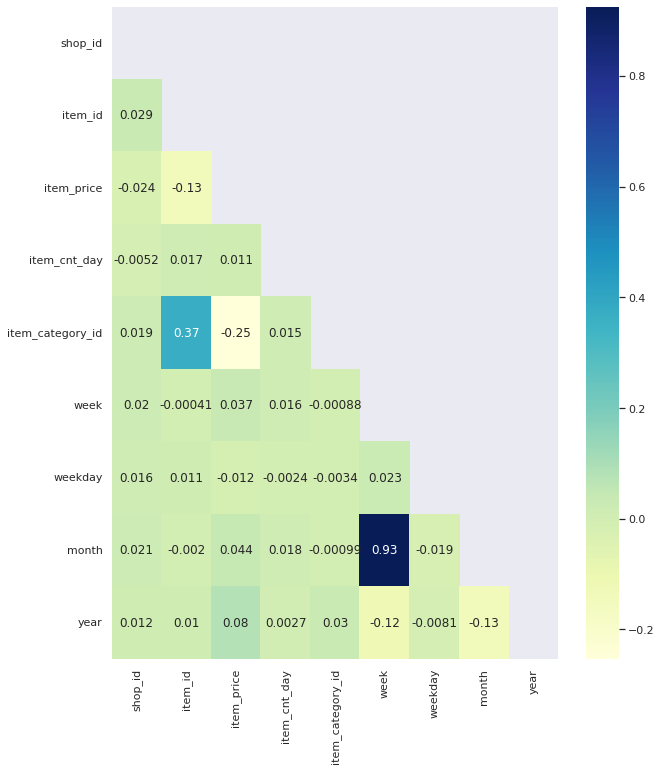

In [ ]:
cor_up = np.triu(temp_df[['shop_id','item_id','item_price','item_cnt_day', 'item_category_id','week', 'weekday', 'month', 'year']].corr())
cor = temp_df[['shop_id','item_id','item_price','item_cnt_day', 'item_category_id','week', 'weekday', 'month', 'year']].corr()
sns.set(rc={'figure.figsize':{12,10}})
sns.heatmap(cor, annot=True, mask = cor_up, cmap="YlGnBu")

## we should not keep month and week both as they are highly correlated

#### Checking Russian to English conversion

In [ ]:
# !pip install easynmt

In [ ]:
# from googletrans import Translator
# from google_trans_new import google_translator 
# from easynmt import EasyNMT

# translator = google_translator() 
# # final_df['item_category_name_eng'] = final_df['item_category_name'].apply(lambda x: translator.translate(x, lang_tgt='en'))
# # final_df['item_category_name_eng'] = final_df['item_category_name'].apply(lambda x: Translator.translate(x, dest='en').text)


# from easynmt import EasyNMT
# model = EasyNMT("opus-mt")

# final_df["item_category_name_eng"] = final_df.apply(lambda row: model.translate(row["item_category_name"], target_lang="en"), axis=1)
# final_df

In [ ]:
# !pip install google_trans_new

# import the library
import googletrans
from googletrans import Translator

In [ ]:
# from google_trans_new import google_translator

# translator = google_translator()  
# translate_text = translator.translate('Hola Mundo',lang_tgt='en') 
# print(translate_text)

In [ ]:
# translator = Translator()

In [ ]:
# translator.translate('Hola Mundo')

In [ ]:
# translations = {}
# for column in [ 'item_category_name', 'shop_name']:#'item_name',
#     # unique elements of the column
#     temp_df = final_df.loc[final_df[column].notnull()]
#     unique_elements = temp_df[column].unique()
#     print(column)
#     print(unique_elements)
#     for element in unique_elements:
#       pass
#         # add translation to the dictionary
#       translations[element] = translator.translate(element).text
    
# print(translations)

#### 7. Each item's sales proportion in the shop by figuring out [highlight the importance of an item in a shop on a particular day]
		

*   day-level sales count and price sum (group by shop Id, item Id)
*   day-level sales count and price sum (group by shop Id)


		

In [ ]:
# creating the day-level sum dataframe
day_levl_sum_df = final_df.groupby(['date', 'shop_id']).agg({'item_cnt_day':'sum', 'item_price':'sum'}).rename(columns={'item_cnt_day':'item_cnt_day_sum', 'item_price':'item_price_sum'}).reset_index()
day_levl_sum_df

,date,shop_id,item_cnt_day_sum,item_price_sum
0,2013-01-01,2,24.0,31287.0
1,2013-01-01,7,89.0,58595.0
2,2013-01-01,8,50.0,43118.0
3,2013-01-01,13,31.0,5804.0
4,2013-01-01,14,66.0,43673.0
...,...,...,...,...
47223,2015-10-31,55,137.0,38268.0
47224,2015-10-31,56,67.0,48622.0
47225,2015-10-31,57,121.0,105070.0
47226,2015-10-31,58,82.0,85774.0


In [ ]:
## Merging day-level with final_df
final_df_prop = pd.merge(final_df, day_levl_sum_df, how='inner', left_on=['date', 'shop_id'], right_on=['date', 'shop_id'])
print(final_df.shape[0])
print(final_df_prop.shape[0])

2935849
2935849


In [ ]:
# creating the proportion columns out of count, price
final_df_prop['cnt_prop'] = (final_df_prop['item_cnt_day'] / final_df_prop['item_cnt_day_sum'])*100
final_df_prop['price_prop'] = (final_df_prop['item_price'] / final_df_prop['item_price_sum'])*100
final_df_prop.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,item_cnt_day_sum,item_price_sum,cnt_prop,price_prop
0,2013-01-02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",155.0,129256.0,0.645161,0.772885
1,2013-01-02,0,59,5994,298.0,1.0,"RAGE [PC, Jewel, русская версия]",30,Игры PC - Стандартные издания,"Ярославль ТЦ ""Альтаир""",155.0,129256.0,0.645161,0.230550
2,2013-01-02,0,59,6093,349.0,1.0,"Rayman Origins [PC, Jewel, русская версия]",30,Игры PC - Стандартные издания,"Ярославль ТЦ ""Альтаир""",155.0,129256.0,0.645161,0.270007
3,2013-01-02,0,59,6095,1699.0,1.0,"Rayman Origins [PS Vita, русская документация]",22,Игры - PSVita,"Ярославль ТЦ ""Альтаир""",155.0,129256.0,0.645161,1.314446
4,2013-01-02,0,59,6123,2499.0,1.0,"Resident Evil 6 [Xbox 360, русские субтитры]",23,Игры - XBOX 360,"Ярославль ТЦ ""Альтаир""",155.0,129256.0,0.645161,1.933373


In [ ]:
# for each shop, this prop columns should sum upto 100
final_df_prop.groupby(['date','shop_id']).agg({'cnt_prop':'sum', 'price_prop':'sum'}).reset_index()

,date,shop_id,cnt_prop,price_prop
0,2013-01-01,2,100.0,100.0
1,2013-01-01,7,100.0,100.0
2,2013-01-01,8,100.0,100.0
3,2013-01-01,13,100.0,100.0
4,2013-01-01,14,100.0,100.0
...,...,...,...,...
47223,2015-10-31,55,100.0,100.0
47224,2015-10-31,56,100.0,100.0
47225,2015-10-31,57,100.0,100.0
47226,2015-10-31,58,100.0,100.0


#### 8. Clustering of shops: We can decide on how big the shop is (depending on the number of items available in that shop, total_sales of the shop) and cluster the shops into multiple groups (small, medium, large) 

In [ ]:
# preparing new df: count of unique items in the shop and total sales
# final_df_prop.groupby(['shop_id','item_id']).size().reset_index(name='count_items')'item_id':pd.Series.nunique
shop_item_df = final_df_prop.groupby(['shop_id','item_id'], as_index=False).agg({'item_cnt_day':'sum', 'item_price':'sum'}).rename(columns={'item_cnt_day':'item_cnt_day_sum', 'item_price':'item_price_sum'})
shop_item_df

,shop_id,item_id,item_cnt_day_sum,item_price_sum
0,0,30,31.0,2385.0
1,0,31,11.0,3038.0
2,0,32,16.0,2431.0
3,0,33,6.0,2082.0
4,0,35,15.0,2964.0
...,...,...,...,...
424119,59,22154,1.0,999.0
424120,59,22155,1.0,149.0
424121,59,22162,16.0,6234.0
424122,59,22164,6.0,4344.0


##### 8.a Shop Clusters

In [ ]:
# grouping based on shops
shop_grp_df = shop_item_df.groupby(['shop_id'], as_index=False).agg({'item_id':pd.Series.nunique, 'item_cnt_day_sum':'sum', 'item_price_sum': 'sum'})
shop_grp_df.head()

,shop_id,item_id,item_cnt_day_sum,item_price_sum
0,0,3600,11705.0,5.553869e+06
1,1,2523,6311.0,2.926161e+06
2,2,4849,30620.0,3.510444e+07
3,3,5261,28355.0,2.647262e+07
4,4,7309,43942.0,3.533539e+07


In [ ]:
from sklearn.cluster import KMeans
#here you select your columns
X = shop_grp_df[['item_id', 'item_cnt_day_sum', 'item_price_sum']]

Sum_of_squared_distances = []
K = range(1,50)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

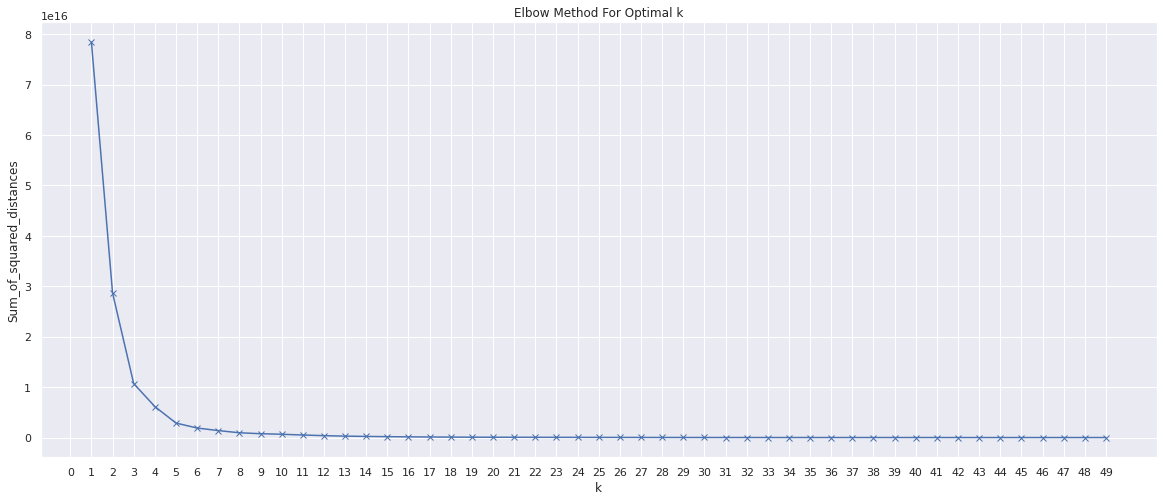

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(np.arange(0, 50, 1.0))
plt.show()

# so for shops it seems we can have 6 clusters

In [ ]:
km = KMeans(n_clusters=6)
km = km.fit(X)
shop_grp_df['shop_clusters'] = km.predict(X).tolist()
shop_grp_df

,shop_id,item_id,item_cnt_day_sum,item_price_sum,shop_clusters
0,0,3600,11705.0,5.553869e+06,3
1,1,2523,6311.0,2.926161e+06,3
2,2,4849,30620.0,3.510444e+07,5
3,3,5261,28355.0,2.647262e+07,0
4,4,7309,43942.0,3.533539e+07,5
5,5,7084,42762.0,3.326088e+07,5
6,6,11856,100489.0,7.455831e+07,2
7,7,8246,67058.0,5.607710e+07,2
8,8,1909,3595.0,2.226273e+06,3
9,9,1404,15866.0,4.714303e+06,3


####9. Grouping Dataframe based on test-dataset columns

In [ ]:
# grouping the dataframe 
df_grp = final_df[[ "date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day",'item_category_id']].groupby(
    ["date_block_num", "shop_id", "item_id"]).agg({"item_price": "sum","item_cnt_day": "sum", 'item_category_id':'first'}).reset_index()

df_grp = df_grp.sort_values(by=['date_block_num'], ascending=True).reset_index(drop=True)
df_grp

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,0,32,884.0,6.0,40
1,0,37,18783,179.0,1.0,37
2,0,37,18789,149.0,1.0,40
3,0,37,18797,248.0,1.0,40
4,0,37,18822,149.0,1.0,40
...,...,...,...,...,...,...
1609119,33,24,9355,349.0,3.0,70
1609120,33,24,9337,899.0,1.0,70
1609121,33,24,8743,169.0,1.0,40
1609122,33,24,8737,3198.0,2.0,38


In [ ]:
# per date_block how many shop_ids and item_ids were there
df_grp.groupby('date_block_num', as_index=False).agg({'shop_id':pd.Series.nunique, 'item_id':pd.Series.nunique, 'item_category_id':pd.Series.nunique})

,date_block_num,shop_id,item_id,item_category_id
0,0,45,8115,56
1,1,46,8168,57
2,2,46,8302,53
3,3,46,8145,54
4,4,45,8339,60
5,5,46,8478,57
6,6,46,8405,59
7,7,45,8031,59
8,8,45,7876,59
9,9,46,8039,61


In [ ]:
df_grp.describe().T
# item_cnt_day when summed at monthly level is still coming negative (which is a concern)

,count,mean,std,min,25%,50%,75%,max
date_block_num,1609124.0,14.664793,9.542322,0.00,6.0,14.0,23.0,33.0
shop_id,1609124.0,32.805848,16.537009,0.00,21.0,31.0,47.0,59.0
item_id,1609124.0,10680.990268,6238.883102,0.00,5045.0,10497.0,16060.0,22169.0
item_price,1609124.0,1625.362975,5701.611253,0.09,249.0,499.0,1398.0,671930.0
item_cnt_day,1609124.0,2.267200,8.649882,-22.00,1.0,1.0,2.0,2253.0
item_category_id,1609124.0,41.541918,16.323652,0.00,30.0,40.0,55.0,83.0


In [ ]:
df_grp[['shop_id','item_id','item_price','item_cnt_day','item_category_id']].corr()
# correlation before and after grouping remains same

,shop_id,item_id,item_price,item_cnt_day,item_category_id
shop_id,1.000000,0.024739,-0.009678,0.000270,0.024449
item_id,0.024739,1.000000,-0.097352,-0.011001,0.296301
item_price,-0.009678,-0.097352,1.000000,0.174070,-0.173935
item_cnt_day,0.000270,-0.011001,0.174070,1.000000,-0.016190
item_category_id,0.024449,0.296301,-0.173935,-0.016190,1.000000


In [ ]:
df_grp[df_grp['item_price']<=0]
# after adding the item price got rid of negative values

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
